In [25]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_2024/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [26]:
# Importing Required Libraries

# Import the MNIST dataset from torchvision
import torchvision

# Import numpy for data manipulation
import numpy as np

# Load the MNIST dataset and download it if necessary
MNIST = torchvision.datasets.MNIST(".", download=True)

# Extract the training data, training labels, test data, and test labels from the MNIST dataset
train_data = MNIST.train_data
train_labels = MNIST.train_labels
test_data = MNIST.test_data
test_labels = MNIST.test_labels

# Combining and Subsampling Data

# Vertically combine the training and test data arrays
data = np.vstack([train_data, test_data])

# Vertically combine the training and test labels arrays
labels = np.hstack([train_labels, test_labels])

# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 20,000 samples from the combined data without replacement
indices = np.random.choice(len(data), size=20000, replace=False)

# Update the 'data' array to include only the selected samples
data = data[indices]

# Update the 'labels' array to include only the labels corresponding to the selected samples
labels = labels[indices]

# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Explanation:
# This code imports the MNIST dataset using torchvision and extracts the training and test data along with their labels.
# It then vertically combines the training and test data arrays, as well as the labels arrays, to create a larger dataset.
# Randomly, 20,000 samples are selected from the combined dataset without replacement to reduce its size.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/yifei/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [27]:
# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 20,000 samples from the combined data without replacement
indices = np.random.choice(len(data), size=20000, replace=False)

# Update the 'data' array to include only the selected samples
data = data[indices]

# Update the 'labels' array to include only the labels corresponding to the selected samples
labels = labels[indices]

# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Reshape the 'labels' array to ensure it is a 2D array
labels = labels.reshape(labels.shape[0], -1)

# Explanation:
# This code combines the training and test datasets and labels to create a larger dataset for analysis.
# It then randomly selects 20,000 samples from the combined dataset without replacement, ensuring randomness and diversity.
# The 'data' and 'labels' arrays are updated to contain only the selected samples.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


In [28]:
data = np.concatenate((labels, data),axis=1)

In [29]:
# import dataset (comes with colab!)


# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader

In [30]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [31]:
# create a class for the model
def createTheMNISTNet(optimizerAlgo,learningrate):

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=learningrate)

  return net,lossfun,optimizer

# Create a function that trains the model

In [32]:
# a function that trains the model

def function2trainTheModel(optimizerAlgo,learningrate):

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(optimizerAlgo,learningrate)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    net.train()
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    net.eval()
    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [33]:
# note: this experiment takes ~30 mins
import sys

# variables to loop over
learningRates = np.logspace(np.log10(.0001),np.log10(.1),6)
optimTypes = ['SGD','RMSprop','Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates),len(optimTypes)))

# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
  for idx_l,lr in enumerate(learningRates):
    trainAcc,testAcc,losses,net = function2trainTheModel(opto,lr)
    finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])
    msg = 'Finished experiment {}: {}'.format(idx_o,idx_l)
    sys.stdout.write('\r' + msg)

Finished experiment 2: 5

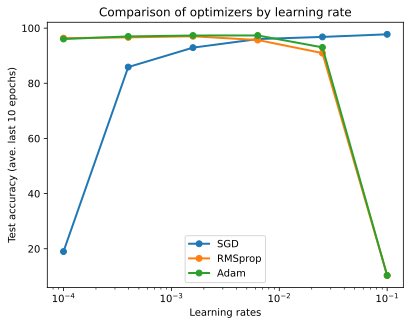

In [34]:
# plot the results! 
plt.plot(learningRates,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

In [ ]:
# Seems like the best learning rate for all optimizier is around 10^-2.4, equal to 4*10^-3
# We choose learningRates = [4e-3]

In [35]:
# create a class for the model
def createTheMNISTNet(optimizerAlgo,learningrate):

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.bnorm1 = nn.BatchNorm1d(32)
      self.fc2 = nn.Linear(32,32)
      self.bnorm2 = nn.BatchNorm1d(32)
      
      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = self.bnorm1(x) # batchnorm
      # Apply Batch Normalization to the output of the first hidden layer.
      x = F.relu( self.fc2(x) )
      x = self.bnorm2(x) # batchnorm
      # Apply Batch Normalization to the output of the second hidden layer.
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=learningrate)

  return net,lossfun,optimizer

In [37]:
selectedLearningRate = 4e-3
numepochs = 100

# initialize performance matrix
finalPerformance = np.zeros((len(optimTypes), 3, numepochs)) # trainAcc, testAcc, losses 

# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
  trainAcc,testAcc,losses,net = function2trainTheModel(opto,lr)
  finalPerformance[idx_o,0,:] = trainAcc
  finalPerformance[idx_o,1,:] = testAcc
  finalPerformance[idx_o,2,:] = losses
  msg = 'Finished experiment {}: {}'.format(idx_o,len(optimTypes))
  sys.stdout.write('\r' + msg)

Finished experiment 2: 5

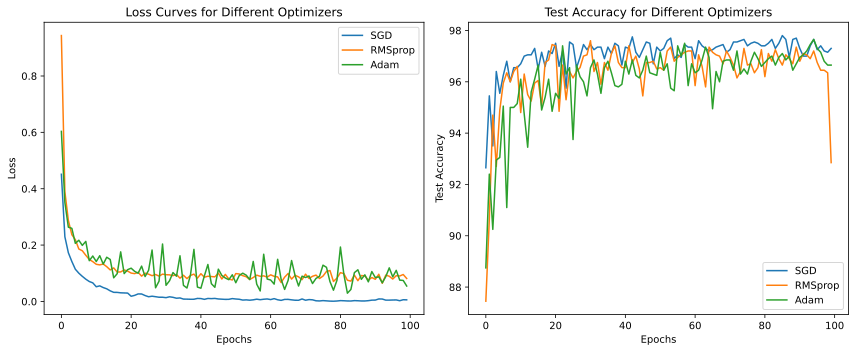

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot losses for each optimizer in the first subplot
for idx_o, opto in enumerate(optimTypes):
    ax1.plot(finalPerformance[idx_o, 2, :], label=opto)
ax1.set_title('Loss Curves for Different Optimizers')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot test accuracy for each optimizer in the second subplot
for idx_o, opto in enumerate(optimTypes):
    ax2.plot(finalPerformance[idx_o, 1, :], label=opto)
ax2.set_title('Test Accuracy for Different Optimizers')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Test Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

# Optional explorations

In [11]:
# 1) Replace the learning rate factor with L2 regularization. Does L2 regularization help all optimization
#    methods in the same way?
# 
# 2) We previously observed the batch normalization boosted model performance. Does it help here as well? 
#    (Note: Best to pick just one learning rate for this experiment.)
# 
# 3) The dataset contains 20,000 images. Do we need that many to get good accuracy? Pick one combination of
#    optimizer and learning rate, and train the model using only 2,000 images. Do you still get >95% accuracy?
#    How about 200 images?
# 